In [13]:
import librosa
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from IPython.display import Audio
import nltk
from nltk.corpus import cmudict
import re

### Load the audio signal (using Librosa).

The sampling rate should be 48kHz.

In [3]:
(y, rate) = librosa.load("260112_001_Tr1.wav", sr=None)

In [5]:
print(f"The sampling rate of the audio signal is {rate}")

The sampling rate of the audio signal is 48000


### Break down the phrase of focus into phonemes (using CMUdict).

The phrase of focus here is "please show me".

In [14]:
# First, download the CMUdict using NLTK
nltk.download('cmudict')

cmu = cmudict.dict()

[nltk_data] Downloading package cmudict to
[nltk_data]     /Users/mattcohen/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [15]:
def strip_stress(phone):
    return re.sub(r"\d", "", phone)

def word_to_phones(word, cmu_dict):
    word = word.lower()
    if word not in cmu_dict:
        raise ValueError(f"Word not in CMUdict: {word}")

    # Use first pronunciation
    phones = cmu_dict[word][0]
    return [strip_stress(p) for p in phones]

In [16]:
sample_words = ["please", "show", "me"]

sample_phonemes = []

for word in sample_words:
    phonemes = word_to_phones(word, cmu_dict=cmu)
    sample_phonemes.append(phonemes)
    print(f"{word}: {phonemes}")


please: ['P', 'L', 'IY', 'Z']
show: ['SH', 'OW']
me: ['M', 'IY']


### Sample the signal to grab the relevant words / phonemes.

Isolate two instances of each phoneme from the signal of interest.

In [59]:
t_start = 10 # Starting time (seconds)
t_end = 14  # Ending time (seconds)

y_sub = y[int(rate*t_start):int(rate*t_end)]

In [60]:
# Play the loaded audio
display(Audio(data=y_sub, rate=rate))

### Plot the sampled audio signal for the phrase "please show me".

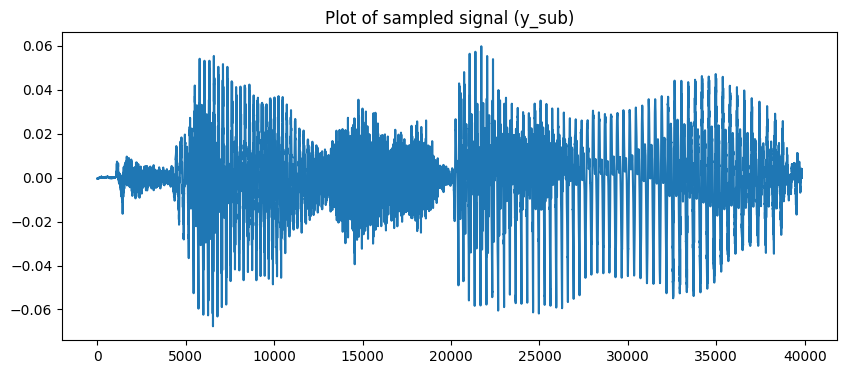

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(y[int(rate*10.17):int(rate*11)])
plt.title('Plot of sampled signal (y_sub)')
plt.show()

In [62]:
display(Audio(data=y[int(rate*10.17):int(rate*11)], rate=rate))

In [105]:
y_please_1 = y[int(rate*10.17):int(rate*10.50)]

In [106]:
display(Audio(data=y_please_1, rate=rate))

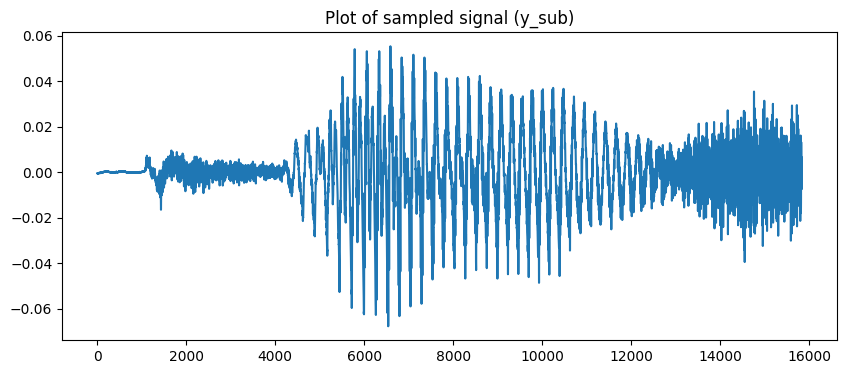

In [109]:
plt.figure(figsize=(10, 4))
plt.plot(y_please_1)
plt.title('Plot of sampled signal (y_sub)')
plt.show()

In [111]:
y_please_p_1 = y_please_1[0:4200]

y_please_l_1 = y_please_1[4200:6000]

y_please_iy_1 = y_please_1[6000:12000]

y_please_z_1 = y_please_1[12000:14000]

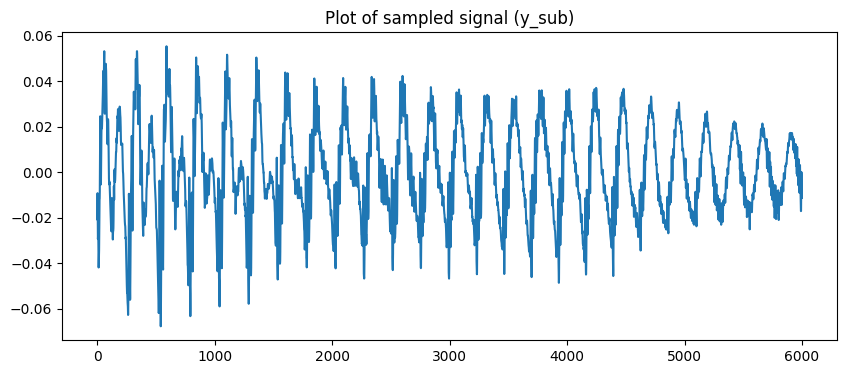

In [114]:
plt.figure(figsize=(10, 4))
plt.plot(y_please_iy_1)
plt.title('Plot of sampled signal (y_sub)')
plt.show()

In [115]:
display(Audio(data=y_please_z, rate=rate))

### Compute LPC coefficients of the phonemes of "please" and convert to spectral envelope.

In [116]:
def lpc_to_envelope(signal, order, sr):
    # Compute the LPC coefficients
    #    The result 'a' contains the filter coefficients [a_1, a_2, ..., a_p] 
    #    The first coefficient a[0] is implicitly 1 in the standard LPC form.
    # The LPC coefficients 'a' define an all-pole filter. The frequency response of this
    # filter gives the spectral envelope.
    a = librosa.lpc(signal, order=order)

    # The 'a' coefficients from librosa are the predictor coefficients (a[1:]), with a[0] being 1
    # For freqz, we use the full 'a' array as the denominator (b=[1], a=a)
    # If the function returns a[1:] only, you'd use a = np.hstack([[1], -a_coeffs])

    # Compute the frequency response of the LPC filter
    # The 'a' coefficients are the denominator of the transfer function [1, a[1], a[2], ...]
    # The numerator is implicitly a constant (gain, related to error variance)
    w, h = scipy.signal.freqz(b=[1], a=a, worN=8192, fs=sr)

    # The result 'h' is complex, take magnitude and convert to dB
    lpc_envelope = np.abs(h)

    # Plot the LPC envelope
    plt.figure(figsize=(10, 6))
    # Plot LPC envelope (in dB scale)
    plt.plot(w, 20 * np.log10(lpc_envelope / np.max(lpc_envelope)), 'r-', linewidth=2, label=f'LPC Envelope (Order {order}) (dB)')

    plt.title('LPC Spectral Envelope')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, sr / 2) # Limit to Nyquist frequency
    plt.show()

    return a, w, h, lpc_envelope


In [117]:
# Define the LPC order
#    A common rule of thumb for speech is 2 + sample rate (kHz) 
#    or a value like 8-16 for 16kHz audio.
order = 7

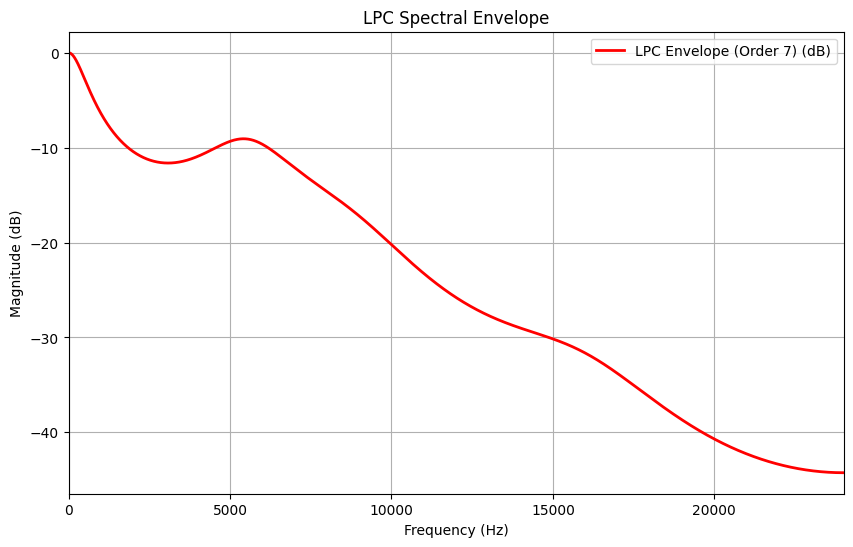

In [143]:
a_please_p_1, w_please_p_1, h_please_p_1, lpc_envelope_please_p_1 = lpc_to_envelope(signal=y_please_p_1, order=order, sr=rate)

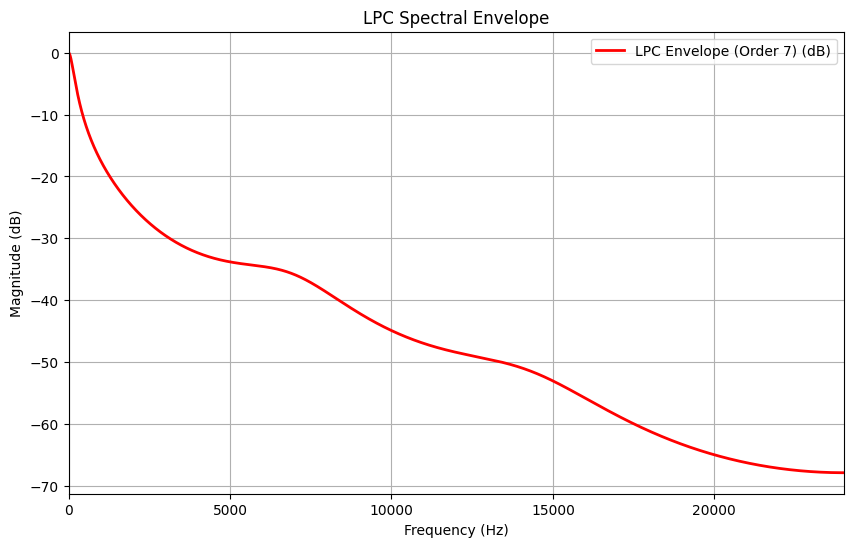

In [144]:
a_please_l_1, w_please_l_1, h_please_l_1, lpc_envelope_please_l_1 = lpc_to_envelope(signal=y_please_l_1, order=order, sr=rate)

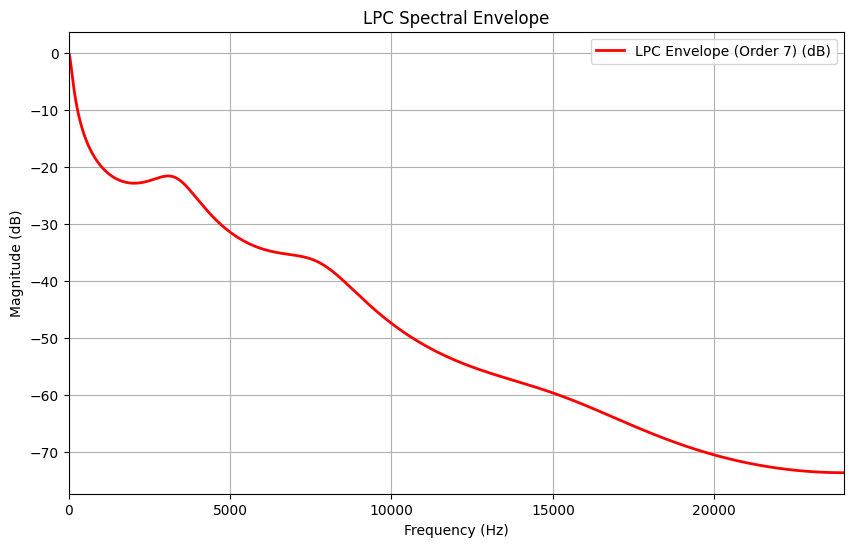

In [145]:
a_please_iy_1, w_please_iy_1, h_please_iy_1, lpc_envelope_please_iy_1 = lpc_to_envelope(signal=y_please_iy_1, order=order, sr=rate)

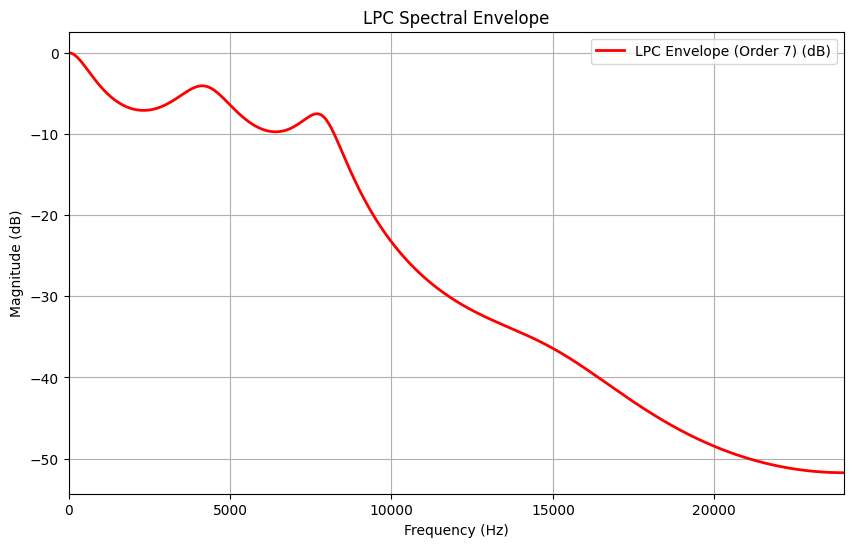

In [146]:
a_please_z_1, w_please_z_1, h_please_z_1, lpc_envelope_please_z_1 = lpc_to_envelope(signal=y_please_z_1, order=order, sr=rate)

### Next, compute the LPC coefficients and spectral envelope for the phonemes of "show".

In [137]:
y_show_1 = y[int(rate*10.50):int(rate*10.67)]

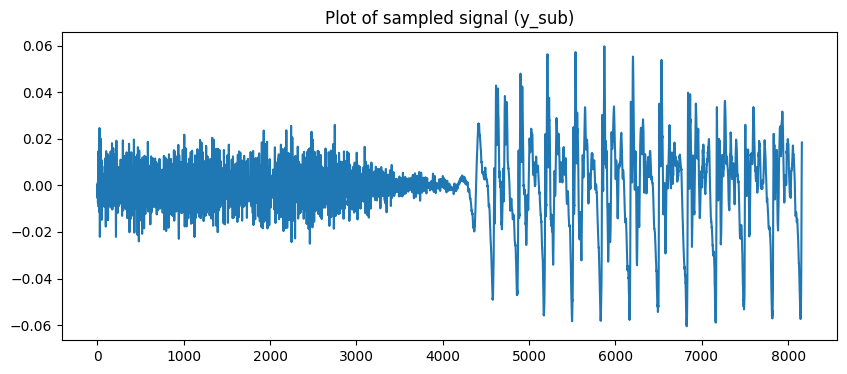

In [138]:
plt.figure(figsize=(10, 4))
plt.plot(y_show_1)
plt.title('Plot of sampled signal (y_sub)')
plt.show()

In [139]:
display(Audio(data=y_show_1, rate=rate))

In [140]:
y_show_sh_1 = y_show_1[0:4200]

y_show_ow_1 = y_show_1[4200:]

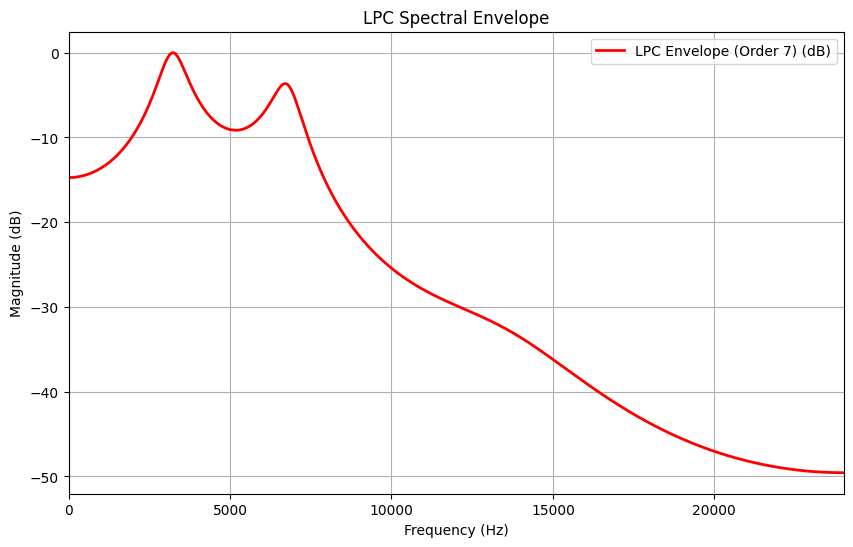

In [147]:
a_show_sh_1, w_show_sh_1, h_show_sh_1, lpc_envelope_show_sh_1 = lpc_to_envelope(signal=y_show_sh_1, order=order, sr=rate)

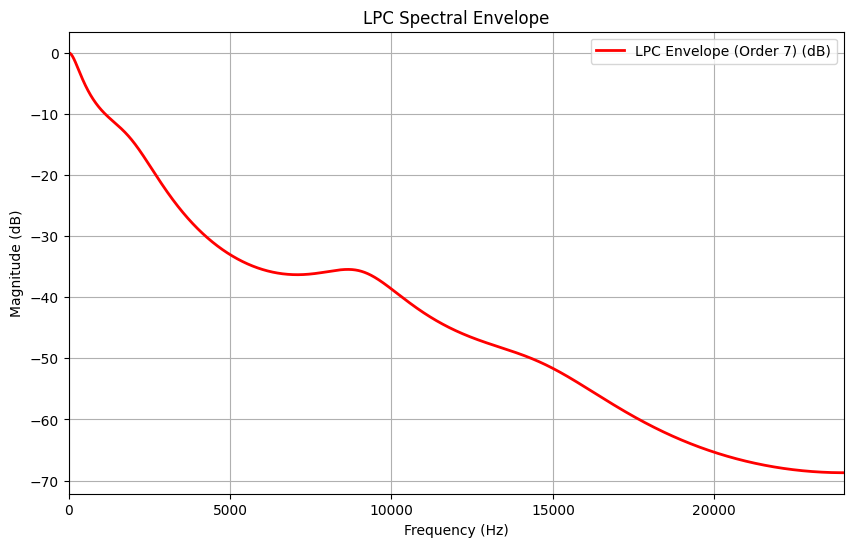

In [148]:
a_show_ow_1, w_show_ow_1, h_show_ow_1, lpc_envelope_show_ow_1 = lpc_to_envelope(signal=y_show_ow_1, order=order, sr=rate)

### Next, compute the LPC coefficients and spectral envelope for the phonemes of "me".

In [167]:
y_me_1 = y[int(rate*10.74):int(rate*11)]

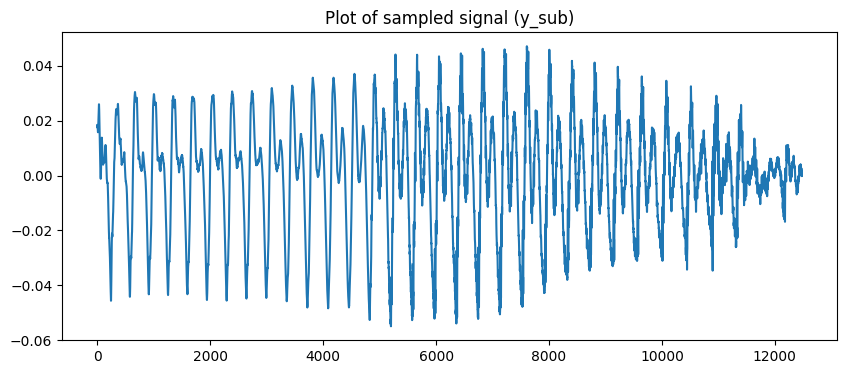

In [168]:
plt.figure(figsize=(10, 4))
plt.plot(y_me_1)
plt.title('Plot of sampled signal (y_sub)')
plt.show()

In [169]:
display(Audio(data=y_me_1, rate=rate))

In [174]:
y_me_m_1 = y_me_1[0:5000]

y_me_iy_1 = y_me_1[5000:]

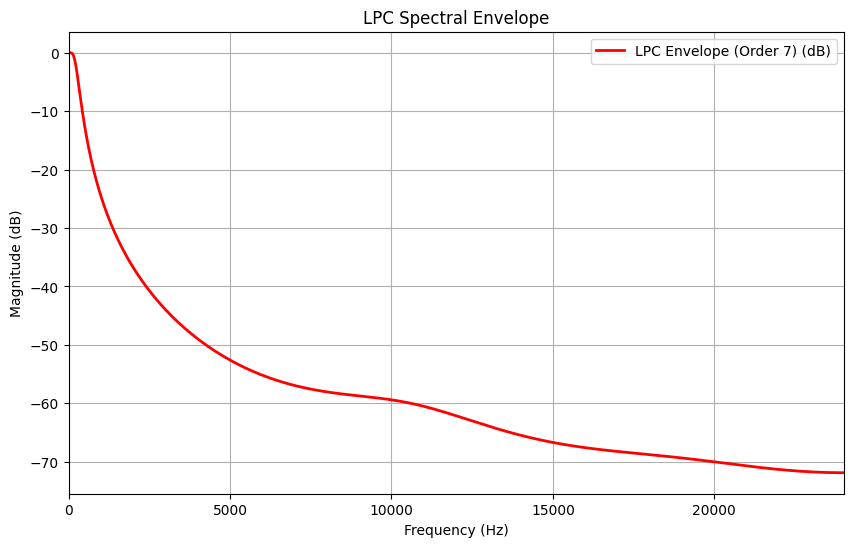

In [175]:
a_me_m_1, w_me_m_1, h_me_m_1, lpc_envelope_me_m_1 = lpc_to_envelope(signal=y_me_m_1, order=order, sr=rate)

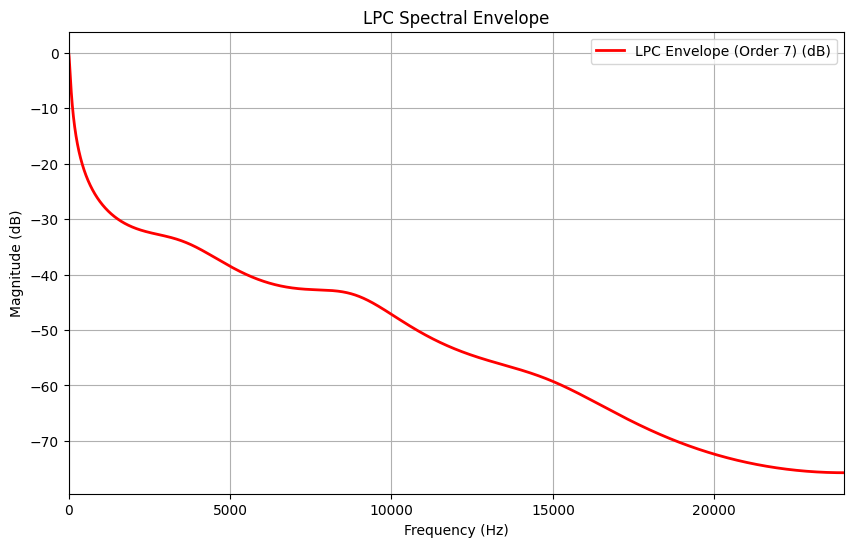

In [176]:
a_me_iy_1, w_me_iy_1, h_me_iy_1, lpc_envelope_me_iy_1 = lpc_to_envelope(signal=y_me_iy_1, order=order, sr=rate)

In [198]:
y_please_2 = y_sub[int(rate*2.685):int(rate*2.9)]

In [199]:
display(Audio(data=y_please_2, rate=rate))

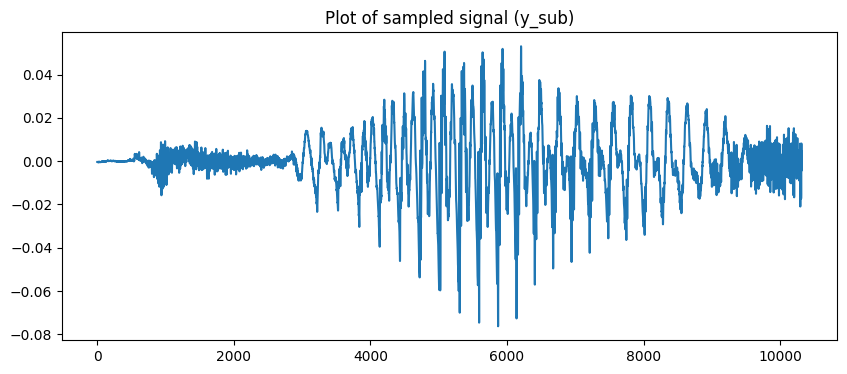

In [200]:
plt.figure(figsize=(10, 4))
plt.plot(y_please_2)
plt.title('Plot of sampled signal (y_sub)')
plt.show()

In [201]:
y_please_p_2 = y_please_2[0:3000]

y_please_l_2 = y_please_2[3000:5000]

y_please_iy_2 = y_please_2[5000:9000]

y_please_z_2 = y_please_2[9000:]

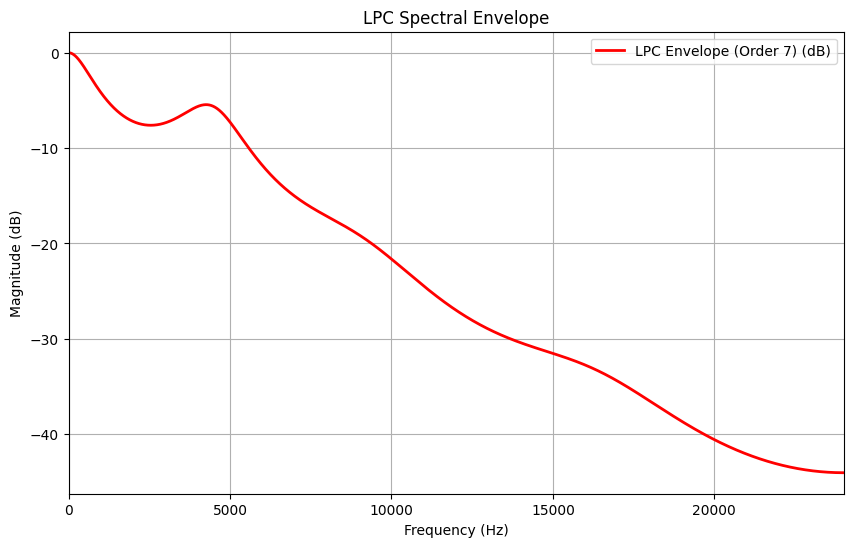

In [206]:
a_please_p_2, w_please_p_2, h_please_p_2, lpc_envelope_please_p_2 = lpc_to_envelope(signal=y_please_p_2, order=order, sr=rate)

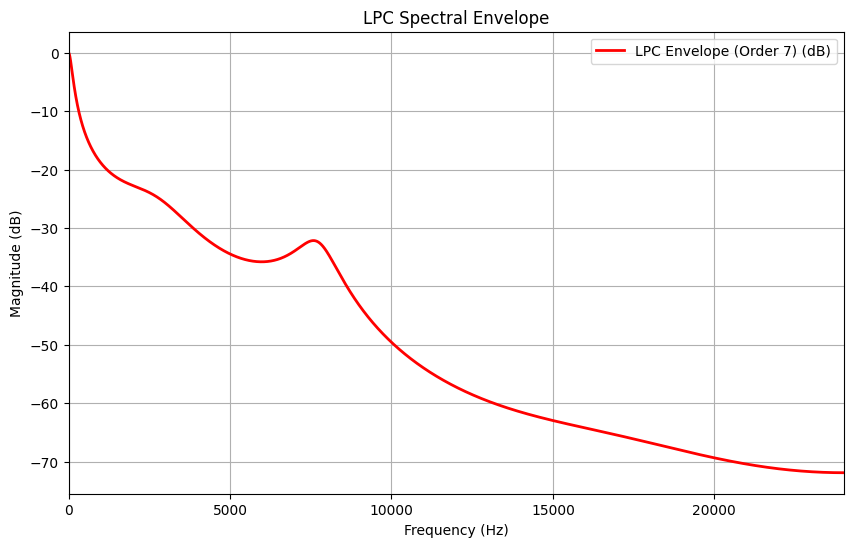

In [207]:
a_please_l_2, w_please_l_2, h_please_l_2, lpc_envelope_please_l_2 = lpc_to_envelope(signal=y_please_l_2, order=order, sr=rate)

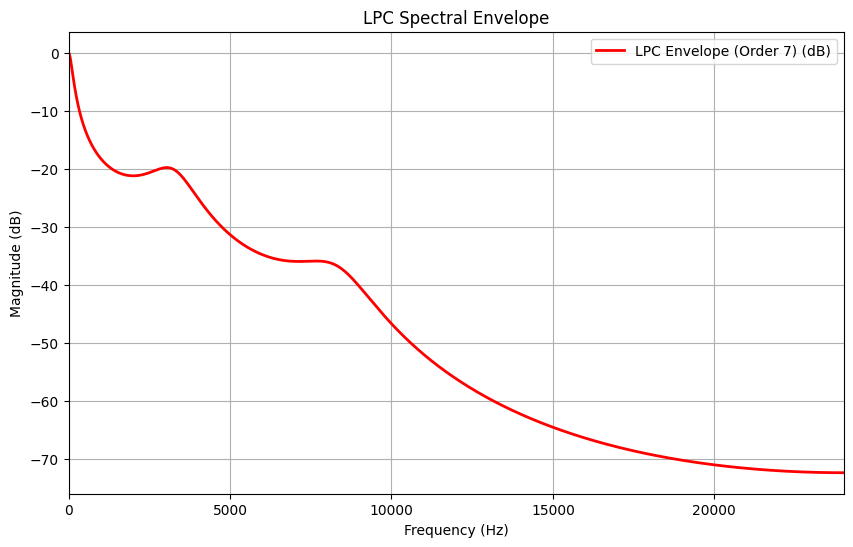

In [208]:
a_please_iy_2, w_please_iy_2, h_please_iy_2, lpc_envelope_please_iy_2 = lpc_to_envelope(signal=y_please_iy_2, order=order, sr=rate)

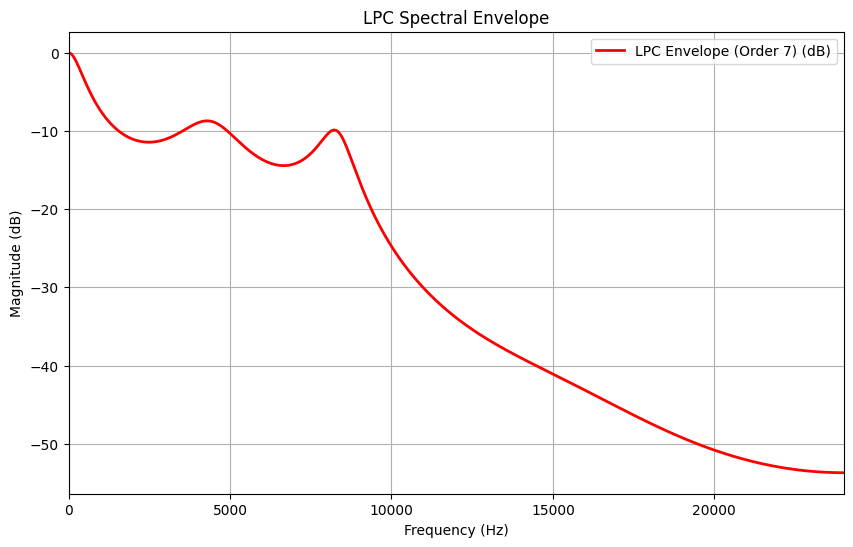

In [209]:
a_please_z_2, w_please_z_2, h_please_z_2, lpc_envelope_please_z_2 = lpc_to_envelope(signal=y_please_z_2, order=order, sr=rate)

### Make plots comparing the spectral envelopes for the phonemes of "please" for different parts of the signal.

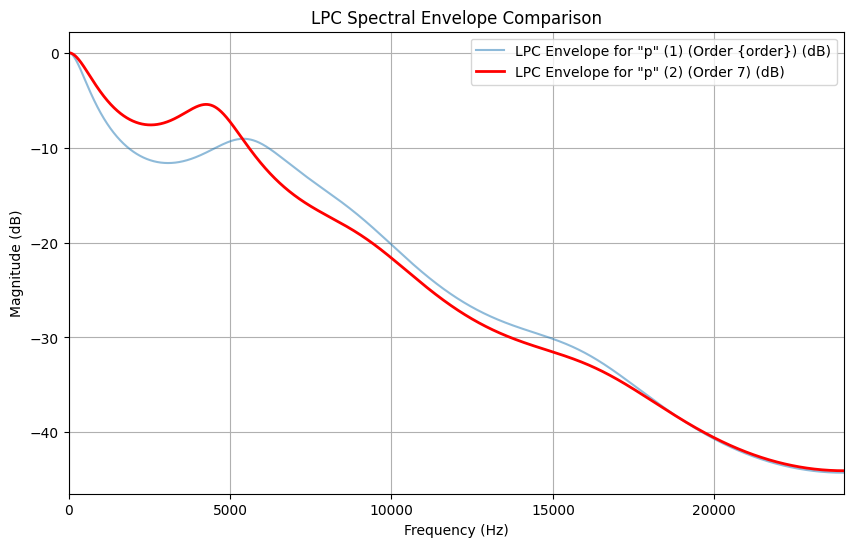

In [211]:
# Plot the spectral envelope for the phoneme at different parts of the signal
plt.figure(figsize=(10, 6))
# Plot first spectral envelope
plt.plot(w_please_p_1, 20 * np.log10(lpc_envelope_please_p_1 / np.max(lpc_envelope_please_p_1)), label='LPC Envelope for "p" (1) (Order {order}) (dB)', alpha=0.5)
# Plot second LPC envelope (in dB scale)
plt.plot(w_please_p_2, 20 * np.log10(lpc_envelope_please_p_2 / np.max(lpc_envelope_please_p_2)), 'r-', linewidth=2, label=f'LPC Envelope for "p" (2) (Order {order}) (dB)')

plt.title('LPC Spectral Envelope Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.xlim(0, rate / 2) # Limit to Nyquist frequency
plt.show()

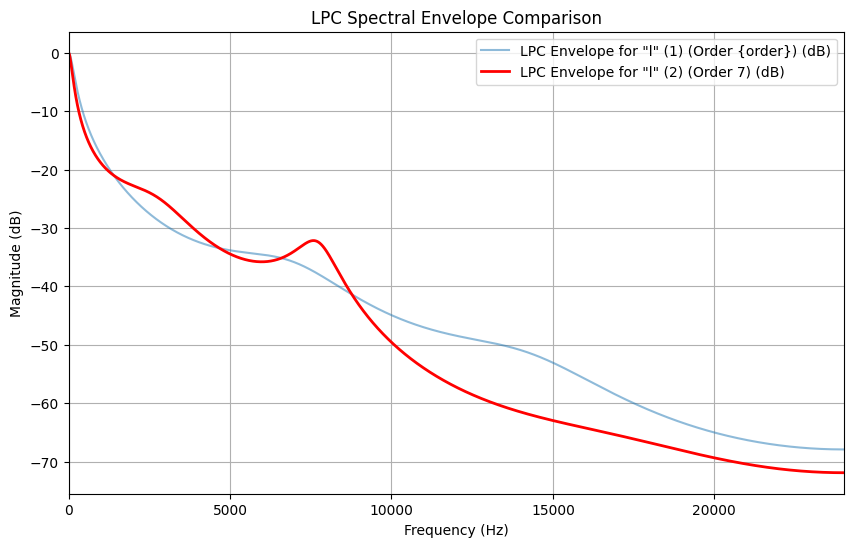

In [215]:
# Plot the spectral envelope for the phoneme at different parts of the signal
plt.figure(figsize=(10, 6))
# Plot first spectral envelope
plt.plot(w_please_l_1, 20 * np.log10(lpc_envelope_please_l_1 / np.max(lpc_envelope_please_l_1)), label='LPC Envelope for "l" (1) (Order {order}) (dB)', alpha=0.5)
# Plot second LPC envelope (in dB scale)
plt.plot(w_please_l_2, 20 * np.log10(lpc_envelope_please_l_2 / np.max(lpc_envelope_please_l_2)), 'r-', linewidth=2, label=f'LPC Envelope for "l" (2) (Order {order}) (dB)')

plt.title('LPC Spectral Envelope Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.xlim(0, rate / 2) # Limit to Nyquist frequency
plt.show()

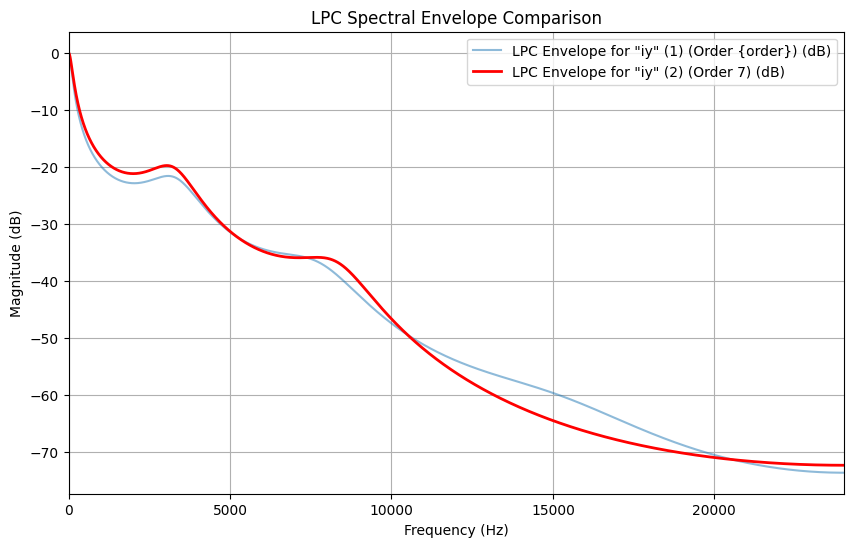

In [213]:
# Plot the spectral envelope for the phoneme at different parts of the signal
plt.figure(figsize=(10, 6))
# Plot first spectral envelope
plt.plot(w_please_iy_1, 20 * np.log10(lpc_envelope_please_iy_1 / np.max(lpc_envelope_please_iy_1)), label='LPC Envelope for "iy" (1) (Order {order}) (dB)', alpha=0.5)
# Plot second LPC envelope (in dB scale)
plt.plot(w_please_iy_2, 20 * np.log10(lpc_envelope_please_iy_2 / np.max(lpc_envelope_please_iy_2)), 'r-', linewidth=2, label=f'LPC Envelope for "iy" (2) (Order {order}) (dB)')

plt.title('LPC Spectral Envelope Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.xlim(0, rate / 2) # Limit to Nyquist frequency
plt.show()

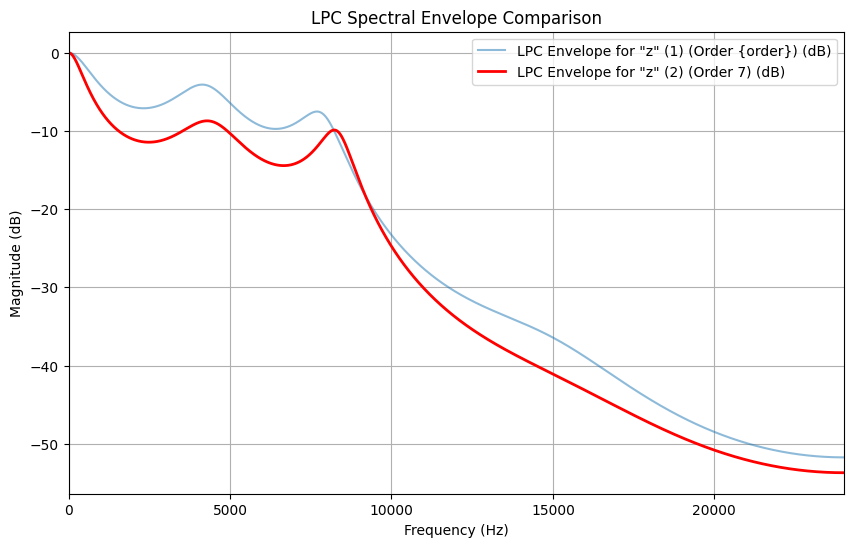

In [214]:
# Plot the spectral envelope for the phoneme at different parts of the signal
plt.figure(figsize=(10, 6))
# Plot first spectral envelope
plt.plot(w_please_z_1, 20 * np.log10(lpc_envelope_please_z_1 / np.max(lpc_envelope_please_z_1)), label='LPC Envelope for "z" (1) (Order {order}) (dB)', alpha=0.5)
# Plot second LPC envelope (in dB scale)
plt.plot(w_please_z_2, 20 * np.log10(lpc_envelope_please_z_2 / np.max(lpc_envelope_please_z_2)), 'r-', linewidth=2, label=f'LPC Envelope for "z" (2) (Order {order}) (dB)')

plt.title('LPC Spectral Envelope Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.xlim(0, rate / 2) # Limit to Nyquist frequency
plt.show()

### Save the spectral envelope results to file.

In [225]:
np.save('freq.npy', w_please_iy_2)

In [226]:
def envelope_to_db(lpc_envelope):
    return 20 * np.log10(lpc_envelope / np.max(lpc_envelope))

In [227]:
np.save('spectrum_please_p.npy', envelope_to_db(lpc_envelope_please_p_1))

np.save('spectrum_please_l.npy', envelope_to_db(lpc_envelope_please_l_1))

np.save('spectrum_please_iy.npy', envelope_to_db(lpc_envelope_please_iy_1))

np.save('spectrum_please_z.npy', envelope_to_db(lpc_envelope_please_z_1))

np.save('spectrum_show_sh.npy', envelope_to_db(lpc_envelope_show_sh_1))

np.save('spectrum_show_ow.npy', envelope_to_db(lpc_envelope_show_ow_1))

np.save('spectrum_me_m.npy', envelope_to_db(lpc_envelope_me_m_1))

np.save('spectrum_me_iy.npy', envelope_to_db(lpc_envelope_me_iy_1))